In [7]:
import torch
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
import h5py

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
import sys
import os
sys.path.append(os.path.join('..', '..', '..' ))

from shared.cifar10_dvs_dataset import CIFAR10DVSData

data_handler = CIFAR10DVSData(save_to='../../../shared/datasets')
data_handler.check_and_download()

train_dataloader, val_dataloader, test_dataloader = data_handler.get_frame_dataloader(batch_size=128, train_ratio=0.7)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIFAR10DVS Data handler initialized. Data will be saved to '../../../shared/datasets'
Download check complete.
Splited dataset into:
 - Training set: 7000 samples
 - Validation set: 1500 samples
 - Test set: 1500 samples


Shape of a frame-based data batch: torch.Size([128, 1, 32, 32])
Labels of the batch: tensor([3, 7, 3, 9, 1, 0, 9, 0, 2, 6, 8, 3, 7, 9, 6, 6, 6, 8, 0, 2, 5, 6, 4, 7,
        6, 0, 0, 6, 2, 0, 5, 2, 3, 1, 8, 4, 5, 9, 5, 5, 6, 7, 5, 4, 3, 2, 4, 5,
        2, 3, 6, 8, 8, 5, 2, 6, 4, 0, 7, 1, 0, 7, 6, 7, 8, 5, 4, 4, 9, 4, 0, 6,
        8, 1, 6, 6, 0, 8, 4, 0, 3, 6, 2, 8, 2, 5, 8, 0, 1, 5, 8, 0, 9, 6, 5, 4,
        8, 2, 7, 2, 2, 1, 1, 0, 5, 2, 5, 2, 2, 5, 0, 4, 3, 5, 7, 5, 5, 1, 2, 5,
        6, 0, 3, 0, 8, 9, 2, 1])


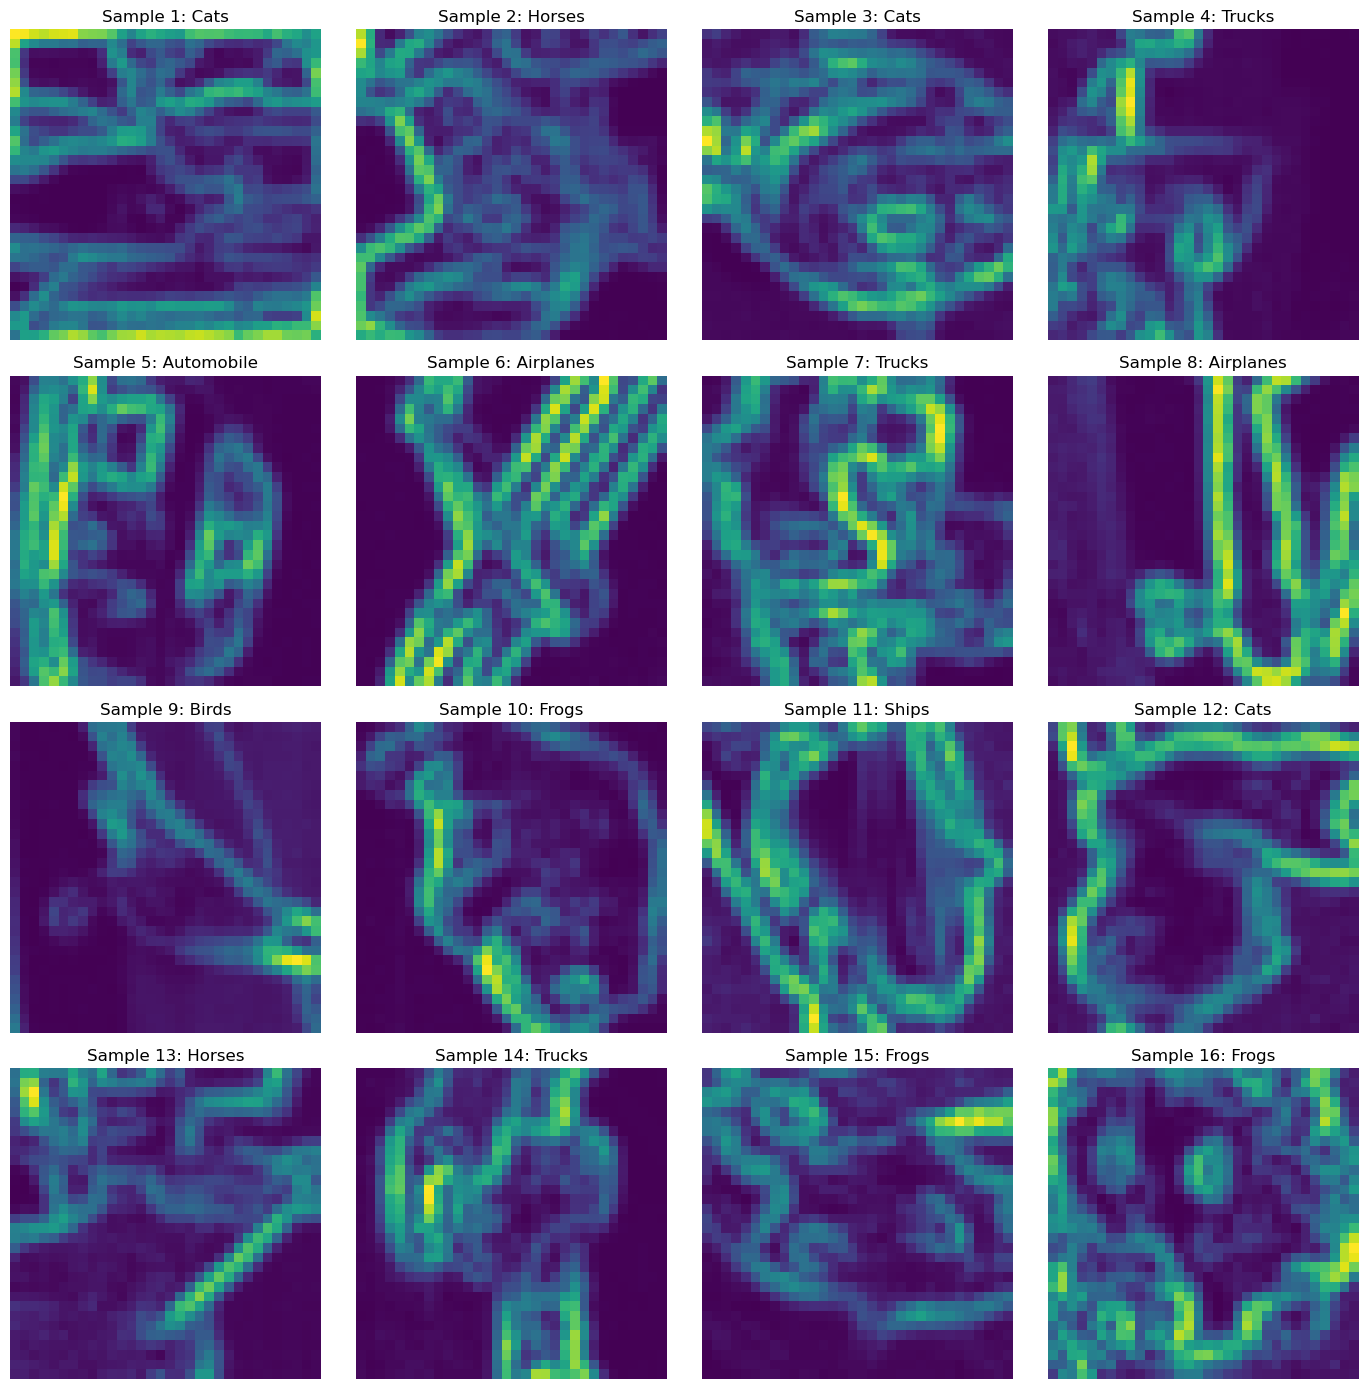

In [10]:
import matplotlib.pyplot as plt

# Get one batch from the train_dataloader
samples, labels = next(iter(train_dataloader))
print(f"Shape of a frame-based data batch: {samples.shape}")
print(f"Labels of the batch: {labels}")


batch_size = samples.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(14, 14))  # For batch_size=16
axes = axes.flatten()

for i in range(16):
    sample_img = samples[i, 0]  # shape: [H, W]
    ax = axes[i]
    ax.imshow(sample_img)
    label_index = labels[i].item()
    label_name = data_handler.labels[label_index]
    ax.set_title(f"Sample {i+1}: {label_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
import torch
import torch.nn as nn

class VGG9Bootstrap(torch.nn.Module):
    def __init__(self, time_steps=16):
        super().__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold': 1.25,
            'current_decay': 1,
            'voltage_decay': 0.03,
            'tau_grad': 1,
            'scale_grad': 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }

        self.blocks = torch.nn.ModuleList([
            
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),
            
            bootstrap.block.cuba.Dense(neuron_params_norm, 32*32, 64, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Dense(neuron_params_norm, 64, 64, weight_norm=True, weight_scale=2),
            
            bootstrap.block.cuba.Dense(neuron_params_norm, 64, 128, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Dense(neuron_params_norm, 128, 128, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Dense(neuron_params_norm, 128, 256, weight_norm=True, weight_scale=2),
           
            bootstrap.block.cuba.Dense(neuron_params_norm, 256, 256, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Affine(neuron_params, 256, 10, weight_norm=True, weight_scale=2),
        ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)

        return x

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        simulation = h.create_group('simulation')
        simulation['Ts'] = 1
        simulation['tSample'] = self.time_steps        
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [21]:
net = VGG9Bootstrap().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [22]:
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

In [23]:
from shared.system_monitor import SystemMonitor

monitor = SystemMonitor(sample_interval=1.0)

In [ ]:
import torch.nn.functional as F

monitor.start()

epochs = 100
for epoch in range(epochs):
    for i, (input, label) in enumerate(train_dataloader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        loss = F.cross_entropy(rate, label.to(device))
        prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    for i, (input, label) in enumerate(test_dataloader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

            loss = F.cross_entropy(rate, label.to(device))
            prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_accuracy:
            torch.save(net.state_dict(), '/network.pt')
        scheduler.update_snn_stat()
            
    stats.update()
    stats.save('/')

monitor.stop()

System monitor started.
